# Predicting Donation Projects Outcome Based on DonorsChoose.org Data

#### Author: Kunyu He
#### University of Chicago CAPP'20

### Executive Summary

In this notebook, I use both Random Forest and XGBoost to predict whether a donation project posted on DonorsChoose.org can get fully funded, based on information on resources they requested, essays they posted and their other characters. Training and test sets are split from projects posted before 01/01/2014. I used data outputs from the [Feature Engineering notebook](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/6d8c5d76-ea9f-4bf6-9b8a-3a0b09fb80cc/view?access_token=91df3b3a5ba72d70b2b60a9358fcdd1aa23098a6cc2acd4879fb39659013711d) stored on [IBM Cloud Object Storage](https://www.ibm.com/cloud/object-storage?S_PKG=AW&cm_mmc=Search_Google-_-Cloud_Cloud+Platform-_-WW_NA-_-+ibm++object++storage_Broad_&cm_mmca1=000016GC&cm_mmca2=10007090&cm_mmca7=9060146&cm_mmca8=aud-311016886972:kwd-346458796492&cm_mmca9=_k_CjwKCAiAyfvhBRBsEiwAe2t_i-XCqy6aVw7VL5rPgPbazlACBDB8tL5qFioP_k0oLEF8dxisH8cTlBoClHoQAvD_BwE_k_&cm_mmca10=317209285867&cm_mmca11=b&mkwid=_k_CjwKCAiAyfvhBRBsEiwAe2t_i-XCqy6aVw7VL5rPgPbazlACBDB8tL5qFioP_k0oLEF8dxisH8cTlBoClHoQAvD_BwE_k_|1445|530530&cvosrc=ppc.google.%2Bibm%20%2Bobject%20%2Bstorage&cvo_campaign=000016GC&cvo_crid=317209285867&Matchtype=b&gclid=CjwKCAiAyfvhBRBsEiwAe2t_i-XCqy6aVw7VL5rPgPbazlACBDB8tL5qFioP_k0oLEF8dxisH8cTlBoClHoQAvD_BwE) in `.csv` format. The models are trained and tuned based on the training set, and evaluated based on the test set. I use test AUC as my evaluating metrics.

Models are first built with default parameters and tuned with grid search based on cross-validation. After tuning, random forest achieves a test accuracy of 74.679%, test AUC of 0.633. Most important features, according to random forest, include:

* Total price the project requested, including and excluding optional tip that donors give to DonorsChoose.org
* Number of items requsted, maximum, median, and minimum unit prices of the items
* Word count for need statement, short description and title of the projects
* Number of students reached

### Methodology

#### 1. Random Forest

Random forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. *(Source: [Wikipedia](https://en.wikipedia.org/wiki/Random_forest))*

The randomness in random forests originates in two facts: each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set; in addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features, but is instead, the best split among a random subset of the features. *(Source: [scikit-learn User Guide](https://scikit-learn.org/stable/modules/ensemble.html#forest))*

Random forest is considered a very handy and easy to use algorithm, because the number of hyperparameters is not that high, and they are straightforward to understand. Overfitting hardly happens in random forests, once there are enough trees in the forest.

However, since random forest is based on bagging, to achieve good performance we need a large number of very deep trees, which makes the training process rather slow on large data sets.

#### 2. XGBoost

### Training Preparations

#### 1. Imports and Session Info

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

from matplotlib.font_manager import FontProperties
from IPython import sys_info
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier

In [3]:
%matplotlib inline

title = FontProperties()
title.set_family('serif')
title.set_size(14)
title.set_weight("semibold")

axis = FontProperties()
axis.set_family('serif')
axis.set_size(12)
axis.set_weight("roman")

ticks = FontProperties()
ticks.set_family('serif')
ticks.set_size(10)

plt.rcParams['figure.figsize'] = [12, 8]

This notebook is built on a **Python 3.5** kernel. Analysis is performed on [IBM Watson Studio](https://dataplatform.cloud.ibm.com/home?context=analytics). For reproducibility, session information is listed below.

In [4]:
print(sys_info())

{'commit_hash': 'd86648c5d',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/IPython',
 'ipython_version': '6.1.0',
 'os_name': 'posix',
 'platform': 'Linux-4.4.0-141-generic-x86_64-with-centos-7.6.1810-Core',
 'sys_executable': '/opt/conda/envs/DSX-Python35/bin/python',
 'sys_platform': 'linux',
 'sys_version': '3.5.5 |Anaconda, Inc.| (default, May 13 2018, 21:12:35) \n'
                '[GCC 7.2.0]'}


#### 2. Load Data

Use the chunks below to list the data assets in my IBM Cloud Object Storage linked to this project. As it includes my credentials, the code is hidden from unauthorized viewers.

In [5]:
# The code was removed by Watson Studio for sharing.

In [6]:
project.get_files()

[{'asset_id': '945f71e4-c723-4cbd-a71c-381eaadb0ba1',
  'name': 'Donation-Projects-Outcome-Prediction.data.X_train.csv'},
 {'asset_id': '7a2d8b2c-65c5-4258-8605-b95653bd30c5',
  'name': 'Donation-Projects-Outcome-Prediction.data.test.csv'},
 {'asset_id': '71dda0d1-cf32-4124-8170-64c425d52820',
  'name': 'Donation-Projects-Outcome-Prediction.data.y_test.csv'},
 {'asset_id': '4aaa220a-3d1e-48fe-a563-0410d08290f2',
  'name': 'Donation-Projects-Outcome-Prediction.data.train_features.csv'},
 {'asset_id': 'f5450447-79fb-4b53-b646-5fbb9a220a8f',
  'name': 'Donation-Projects-Outcome-Prediction.data.train.csv'},
 {'asset_id': '977cdb81-5861-4ef9-a937-190339b4f8fb',
  'name': 'Donation-Projects-Outcome-Prediction.data.y_train.csv'},
 {'asset_id': '4cd74b0a-1df2-4f6a-914c-6f095c4a16a1',
  'name': 'Donation-Projects-Outcome-Prediction.data.X_test.csv'},
 {'asset_id': 'b6920713-693a-454e-855f-a24c95efd8ce',
  'name': 'Donation-Projects-Outcome-Prediction.data.projects.csv'},
 {'asset_id': '9b1c8961

In [7]:
X_train = np.array(pd.read_csv(project.get_file('Donation-Projects-Outcome-Prediction.data.X_train.csv'), header=None))
y_train = np.array(pd.read_csv(project.get_file('Donation-Projects-Outcome-Prediction.data.y_train.csv'), header=None))
X_test = np.array(pd.read_csv(project.get_file('Donation-Projects-Outcome-Prediction.data.X_test.csv'), header=None))
y_test = np.array(pd.read_csv(project.get_file('Donation-Projects-Outcome-Prediction.data.y_test.csv'), header=None))

In [8]:
# The code was removed by Watson Studio for sharing.

#### 3. Auxiliary Functions

Below are some auxiliary functions for hyperparameter tuning.

In [9]:
def evaluate_auc(model, x, y, return_accuracy=False):
    """
    Evaluate classifier based on feature data x and label data y in terms of AUC
    and return accuracy of prediction when requested.
    
    Inputs:
        - model: a trained classifier
        - x: (Numpy Array) feature matrix
        - y: (Numpy Array) label vector
        - return_accuracy: (bool) whether to return accuracy of prediction
    
    Outputs:
        (tuple) accuracy of prediction (conditional), AUC score
    """

    pred = model.predict(x)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, pred)

    accuracy = (pred==y).sum()/len(y)*100
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    if return_accuracy:
        return accuracy, roc_auc
    return roc_auc

In [10]:
def tune_n_estimators(default_model, n_estimators, X_train, y_train, X_test, y_test):
    """
    Take a default tree classifier and a grid of numbers of estimators (trees),
    go through the grid, fit the model and return train and test AUC in separate
    lists.
    
    Inputs:
        - default_model: a unfitted tree classifier
        - n_estimators: (list) grid of numbers of estimators (trees)
    
    Outputs:
        (tuple of lists) list of train AUC, list of test AUC
    """

    train_results = []
    test_results = []

    for estimator in n_estimators:
        model = default_model
        model.set_params(n_estimators=estimator)
        model.fit(X_train, y_train)

        # on training set
        train_results.append(evaluate_auc(model, X_train, y_train))
        # on test set
        test_results.append(evaluate_auc(model, X_test, y_test))

    return train_results, test_results

In [11]:
def visualize_tuning(n_estimators, train_results, test_results, plot_title, legend_loc="best"):
    """
    find the best number of estimators under the certain
    set of parameters, where test AUC is maximized.
    """

    plt.plot(n_estimators, train_results, 'b', label='Train AUC')
    plt.plot(n_estimators, test_results, 'r', label='Test AUC')

    plt.title(plot_title, fontproperties=title)
    plt.ylabel('AUC Score', fontproperties=axis)
    plt.xlabel('Number of Estimators', fontproperties=axis)
    plt.legend(loc=legend_loc, frameon=True, fontsize=12)

    plt.show()
    print("With default individual tree parameters, test AUC is maximized when threr are {} estimators".format( \
          n_estimators[test_results.index(max(test_results))]))

In [12]:
def search(model, grid, X, y, folds=10):
    grid_search = GridSearchCV(model, grid, scoring='roc_auc', cv=folds, return_train_score=True)
    grid_search.fit(X, y)
    print("The best set of paramters to use is {}, which has a cross-validation training AUC of {:.3f}".format( \
          grid_search.best_params_, grid_search.best_score_))
    return grid_search.cv_results_

### Model Training

#### 1. Random Forest

#### a). Test Performance of Random Forest with Default Parameters

In [20]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=123)
rfc.fit(X_train, y_train)
d_accuracy, d_auc = evaluate_auc(rfc, X_test, y_test, return_accuracy=True)

print("Test accuracy is {:.3f}%, test AUC is {:.3f}".format(d_accuracy, d_auc))

Test accuracy is 69.216%, test AUC is 0.632


**Default parameters test performance is not satisfying.** Especially for the test accuracy.

#### b). Tune Number of Trees with Default Parameters

All else held default, tune the **number of trees** in the random forest. **`oob_score` is set to `False` and `criterion` to `gini` as default.**

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=123)
n_estimators = [1, 2, 4, 6, 8] + list(range(10, 210, 10))

train_results, test_results = tune_n_estimators(rfc, n_estimators, X_train, y_train, X_test, y_test)

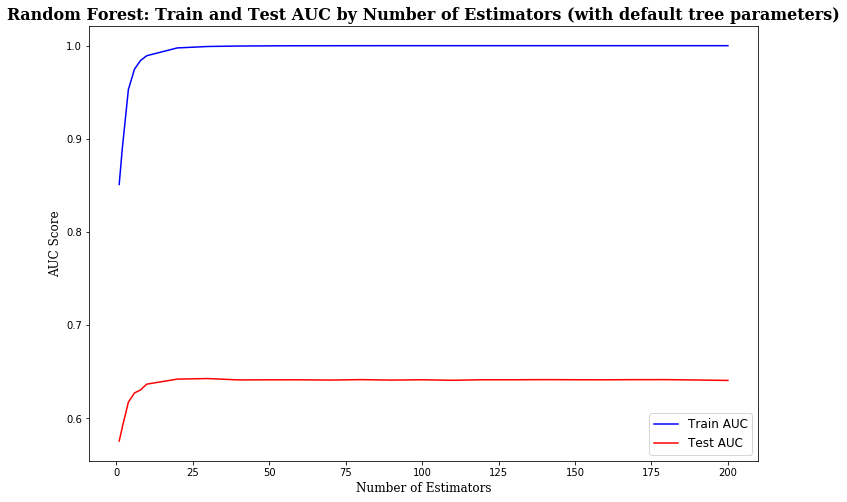

With default individual tree parameters, test AUC is maximized when threr are 30 estimators


In [44]:
visualize_tuning(n_estimators, train_results, test_results,
                 'Random Forest: Train and Test AUC by Number of Estimators (with default tree parameters)')

Set **`n_estimators` to 30**, then use grid search with ten-fold cross validation to find the best set of tree hyperparameters.

#### c). Tune Tree-Specific Parameters

Below I use grid search to tune tree parameters, the evaluation metrics is . First on `max_depth` and `min_samples_split`.

In [27]:
max_depths = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32, None]
min_samples_splits = [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]
grid = {'max_depth' : max_depths, 'min_samples_split': min_samples_splits}

results = search(RandomForestClassifier(n_estimators=30, n_jobs=-1, oob_score=True, random_state=123),
                 grid, X_train, y_train)

The best set of paramters to use is {'min_samples_split': 24, 'max_depth': 20}, which has a cross-validation training AUC of 0.769


Then tune `min_samples_split` and `min_samples_leaf`, as the two paramters are correlated.

In [43]:
min_samples_splits = [range(22, 27)]
min_samples_leaves = [range(1, 11)]
grid = {'min_samples_split': min_samples_splits, 'min_samples_leaf': min_samples_leaves}

results = search(RandomForestClassifier(n_estimators=30, max_depth=20, n_jobs=-1, oob_score=True, random_state=123),
                 grid, X_train, y_train)

The best set of paramters to use is {'min_samples_split': 23, 'min_samples_leaf': 3}, which has a cross-validation training AUC of 0.771


At last, tune `max_features`. Note here this parameter is by default set to `'auto'`, which is actually the square root of number of features, in our case between 9 and 10.

In [65]:
max_features = [range(1, 21, 2)]
grid = {'max_features': max_features}

results = search(RandomForestClassifier(n_estimators=30, max_depth=20, min_samples_split=23, min_samples_leaf=3,
                                        n_jobs=-1, oob_score=True, random_state=123), grid, X_train, y_train)

The best set of paramters to use is {'max_features': 21}, which has a cross-validation training AUC of 0.772


#### d). Benchmak: Test Performance of Random Forest with Tuned Parameters

In [11]:
rfc = RandomForestClassifier(max_depth=20, min_samples_split=23, min_samples_leaf=3, max_features=21,
                             n_jobs=-1, random_state=123)
n_estimators = [1, 2, 4, 6, 8] + list(range(10, 210, 10))

train_results, test_results = tune_n_estimators(rfc, n_estimators, X_train, y_train, X_test, y_test)

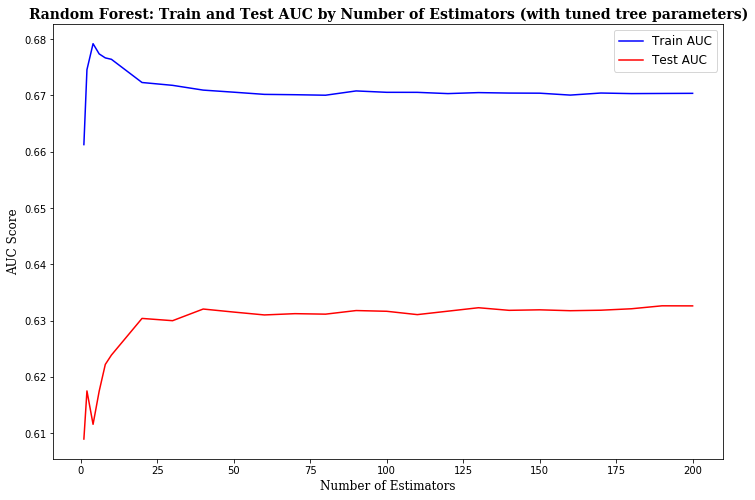

With default individual tree parameters, test AUC is maximized when threr are 190 estimators


In [19]:
visualize_tuning(n_estimators, train_results, test_results,
                 'Random Forest: Train and Test AUC by Number of Estimators (with tuned tree parameters)')

After parameter tuning, evaluate model performance on the test set again.

In [14]:
rfc = RandomForestClassifier(n_estimators=190, max_depth=20, min_samples_split=23, min_samples_leaf=3,
                             max_features=21, n_jobs=-1, random_state=123)
rfc.fit(X_train, y_train)
d_accuracy, d_auc = evaluate_auc(rfc, X_test, y_test, return_accuracy=True)

print("Test accuracy is {:.3f}%, test AUC is {:.3f}".format(d_accuracy, d_auc))

Test accuracy is 74.679%, test AUC is 0.633


We can see **test accuracy improves by approximately 5.463%, test AUC improves moderately**. The tuned random forest builds our benchmark.

#### e). Evaluation: Feature Importance Based on Tuned Random Forest

In [16]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1][:10]
labels = train_features.columns[indices]

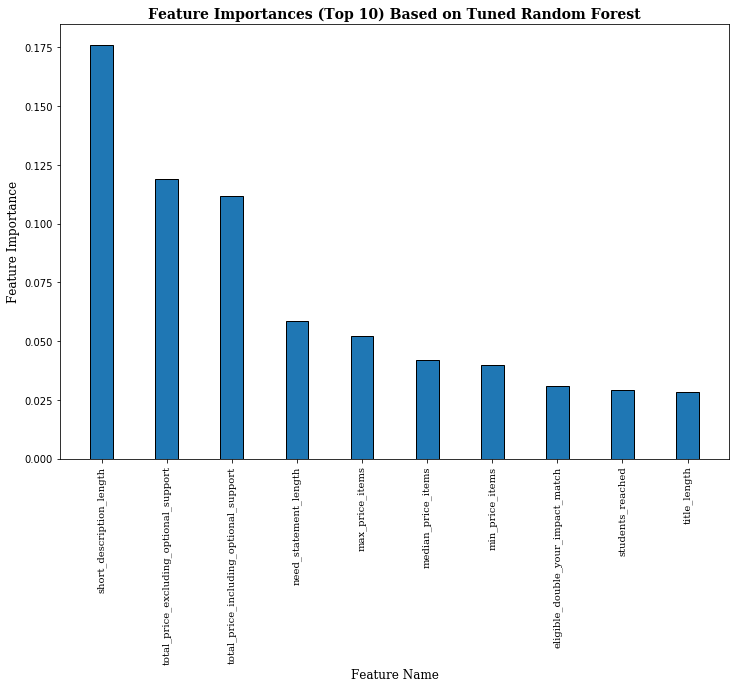

In [17]:
plt.bar(range(len(indices)), importances[indices], width=0.35, align="center", edgecolor=['black']*len(indices))

plt.xlabel("Feature Name", fontproperties=axis)
plt.ylabel("Feature Importance", fontproperties=axis)
plt.title("Feature Importances (Top 10) Based on Tuned Random Forest", fontproperties=title)
plt.xticks(range(len(indices)), labels, rotation='vertical', fontproperties=ticks)

plt.show()

According to our random forest, the ten most important features are:

**1. Lenth of project short description**

**2. Total price requested** (including optional support)

**3. Total price requested** (excluding optional support)

**3. Length of need statement**

**5. Maximum for the price of items requested**

**6. Median for the price of items requested**

**7. Minimum for the price of items requested**

**8. Whether the project was eligible for a 50% off offer by a corporate partner** (logo appears on a project, like Starbucks or Disney)

**9. Number of students reached**

**10. Length of project title**

However, random forest is quite slow on large data set and the performance is not satisfying. Try XGBoost modeling in the following section.

### 2. XGBoost

#### a). Test Performance of XGBoost with Default Parameters

Train a XGBoost classifier with default parameters.

In [15]:
xgbm = XGBClassifier(objective= 'reg:logistic', seed=123)
xgbm.fit(X_train, y_train)
d_accuracy, d_auc = evaluate_auc(xgbm, X_test, y_test, return_accuracy=True)

print("Test accuracy is {:.3f}%, test AUC is {:.3f}".format(d_accuracy, d_auc))

Test accuracy is 74.115%, test AUC is 0.611


**Default parameters test performance is rather satisfying, even as good as tuned random forest on test accuracy.** However, test AUC is rather low.

#### b). Tune Number of Trees with Fixed Learning Rate

Determine the number of trees under default paramters. First we **start with a rather high learning rate `learning_rate=0.1` by default** and determine the optimum number of trees for this learning rate. We use five-fold validation to find the optimal number of estimators.

In [16]:
xgbm_param = xgbm.get_xgb_params()
xgbm_train = xgb.DMatrix(X_train, label=y_train)

cv_result = xgb.cv(xgbm_param, xgbm_train, num_boost_round=xgbm_param['n_estimators'], nfold=5,
                   metrics='auc', as_pandas=True, seed=123)

print("Best number of trees under default parameters is: {}".format(cv_result.shape[0]))

Best number of trees under default parameters is: 100


Seems 100, the default number of estimators is the optimal, but it might merely result from our high learning rate. We'll revisit the problem later.

#### c). Tune Tree-Specific Parameters

First, tune maximum tree depth for base learners *(`max_depth`)* and minimum sum of instance weight(hessian) needed in a child *(`min_child_weight`)*.

In [ ]:
grid = {'max_depth': range(3,10,2), 'min_child_weight': range(1,7,2)}

search(XGBClassifier(objective= 'reg:logistic', n_estimators=100, learning_rate=0.1, seed=123), grid,
       X_train, y_train, folds=5)